In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [2]:
# ap = argparse.ArgumentParser()
# ap.add_argument("-d", "--dataset", required=True,
# 	help="path to input dataset")
# ap.add_argument("-p", "--plot", type=str, default="plot.png",
# 	help="path to output loss/accuracy plot")
# ap.add_argument("-m", "--model", type=str,
# 	default="mask_detector.model",
# 	help="path to output face mask detector model")
# args = vars(ap.parse_args())

usage: ipykernel_launcher.py [-h] -d DATASET [-p PLOT] [-m MODEL]
ipykernel_launcher.py: error: the following arguments are required: -d/--dataset


SystemExit: 2

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [4]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images('dataset'))
data = []
labels = []

for imagePath in imagePaths:

	label = imagePath.split(os.path.sep)[-2]

	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	data.append(image)
	labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

[INFO] loading images...


In [5]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [6]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

In [7]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [8]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
34/34 [==============================] - 10s 279ms/step - loss: 0.5136 - accuracy: 0.7509 - val_loss: 0.1003 - val_accuracy: 0.9710
Epoch 2/20
34/34 [==============================] - 8s 230ms/step - loss: 0.1258 - accuracy: 0.9541 - val_loss: 0.0511 - val_accuracy: 0.9928
Epoch 3/20
34/34 [==============================] - 8s 236ms/step - loss: 0.0810 - accuracy: 0.9747 - val_loss: 0.0348 - val_accuracy: 0.9964
Epoch 4/20
34/34 [==============================] - 8s 234ms/step - loss: 0.0510 - accuracy: 0.9841 - val_loss: 0.0290 - val_accuracy: 0.9964
Epoch 5/20
34/34 [==============================] - 8s 232ms/step - loss: 0.0536 - accuracy: 0.9841 - val_loss: 0.0223 - val_accuracy: 0.9964
Epoch 6/20
34/34 [==============================] - 8s 232ms/step - loss: 0.0309 - accuracy: 0.9906 - val_loss: 0.0181 - val_accuracy: 0.9964
Epoch 7/20
34/34 [==============================] - 8s 231ms/step - loss: 0.0305 - accuracy: 0.9888 - val_loss: 0.0172 - va

In [11]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))
print("[INFO] saving mask detector model...")
model.save('model_classification', save_format="h5")

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       138
without_mask       1.00      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276

[INFO] saving mask detector model...


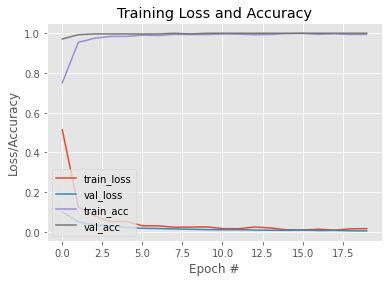

In [13]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('score_graph.png')